# Calculation of Fill Factor fF

Since fF is a ratio. fF = A/B.
A should include all the pixels, including those outside of 1.75 deg.
As of B, we should use 9.6 deg^2. It is simply a normalization factor, and is one of the basic parameters of LSST as defined in the SRD.

In [2]:
import numpy as np
import os
import pandas as pd

In [9]:
dfPath = os.path.join('../../scratchBook/m5_by_amp/m5_output', 'm5_master_db.csv')
mdf = pd.read_csv(dfPath, index_col=0)

In [24]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
for f in filters:
    idx = mdf['m5_%s'%f]>0
    idx1 = (mdf['m5_%s'%f]>0) & (mdf['vendor'] == 'ITL')
    idx2 = (mdf['m5_%s'%f]>0) & (mdf['vendor'] == 'E2V')
    a = sum(idx)
    a1=sum(idx1)
    a2=sum(idx2)
    idx1 = (mdf['m5_%s'%f]>-100) & (mdf['vendor'] == 'ITL')
    idx2 = (mdf['m5_%s'%f]>-100) & (mdf['vendor'] == 'E2V')    
    b = sum(mdf['m5_%s'%f]>-100)
    b1=sum(idx1)
    b2=sum(idx2)
    c = np.median(mdf['m5_%s'%f])
    d = np.median(mdf.loc[idx, 'm5_%s'%f])
    print('%s, good amp = %.0f, total amp =  %.0f, ITL good = %.4f, E2V good = %.4f, m5 median total = %.3f, m5 median good= %.3f'%(
        f, a,b, a1/b1, a2/b2, c, d))

u, good amp = 3011, total amp =  3024, ITL good = 0.9991, E2V good = 0.9936, m5 median total = 24.165, m5 median good= 24.166
g, good amp = 3011, total amp =  3024, ITL good = 0.9991, E2V good = 0.9936, m5 median total = 24.951, m5 median good= 24.952
r, good amp = 3011, total amp =  3024, ITL good = 0.9991, E2V good = 0.9936, m5 median total = 24.472, m5 median good= 24.472
i, good amp = 3011, total amp =  3024, ITL good = 0.9991, E2V good = 0.9936, m5 median total = 24.004, m5 median good= 24.004
z, good amp = 3011, total amp =  3024, ITL good = 0.9991, E2V good = 0.9936, m5 median total = 23.408, m5 median good= 23.408
y, good amp = 3011, total amp =  3024, ITL good = 0.9991, E2V good = 0.9936, m5 median total = 22.467, m5 median good= 22.467


In [20]:
nITL = 8
nE2V = 13
nPixITL = 4072 * 4000 
nPixE2V = 4096 * 4004
pixSize = 0.2**2/3600**2
FOV = 9.6
fF = (9*nITL*nPixITL*a1/b1 + 9*nE2V*nPixE2V*a2/b2) * pixSize / FOV
print('Current estimate: fF = %.2f'%fF)


Current estimate: fF = 0.99


A related quantity is the geometric filling factor, which we don’t use in the metrics
work, but is useful elsewhere. This quantity is the ratio A(r) / B(r), where A(r)
is the area of all science pixels enclosed by the radius r, and B(r) = pi*r^2. 

The below is modified from Peter's notebook, 
https://github.com/yoachim/ScratchStuff/blob/master/maf_chips_on/check_footprint.ipynb

and requires the LSST stack and sims_catUtils

In [1]:
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import chipNameFromRaDec
from lsst.sims.utils import ObservationMetaData
%matplotlib inline
import matplotlib.pylab as plt
from lsst.sims.utils import angularSeparation

In [4]:
mapper = LsstSimMapper()
epoch=2000.

In [5]:
ra, dec = np.meshgrid(np.linspace(-2.1,2.1, 500), np.linspace(-2.1,2.1, 500))

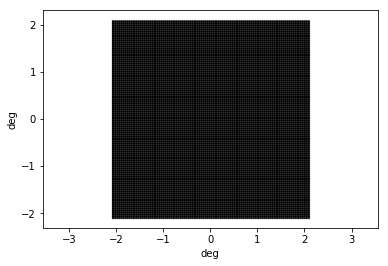

In [6]:
plt.plot(ra,dec, 'ko', markersize=.1);
plt.axis('equal');
plt.xlabel('deg')
plt.ylabel('deg')

In [7]:
obs_metadata = ObservationMetaData(pointingRA=np.degrees(0.),
                                                   pointingDec=np.degrees(0.),
                                                   rotSkyPos=np.degrees(0.),
                                                   mjd=53000)

In [8]:
chipNames = chipNameFromRaDec(ra.ravel(),dec.ravel(),epoch=epoch, camera=mapper.camera, obs_metadata=obs_metadata)

In [9]:
good = np.where((chipNames != [None]))
# Check for other bits
cng = np.array(chipNames[good], dtype='str')
find_char1 = np.char.find(cng, 'R:0,0')
find_char2 = np.char.find(cng, 'R:4,4')
find_char3 = np.char.find(cng, 'R:4,0')
find_char4 = np.char.find(cng, 'R:0,4')

good2 = np.where((find_char1 == -1) & (find_char2 == -1)
                & (find_char3 == -1) & (find_char4 == -1))
good = good[0][good2]
bad = np.where(chipNames == [None])

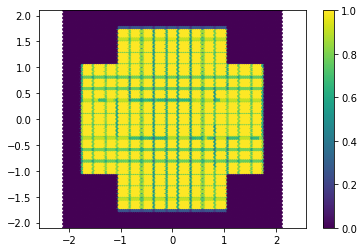

In [10]:
ack = ra.ravel()*0
ack[good] = 1
plt.hexbin(ra.ravel(), dec.ravel(), ack)
plt.colorbar()
#plt.plot(ra.ravel()[good], dec.ravel()[good], 'bo', markersize=.1, alpha=.5)
#plt.plot(ra.ravel()[bad], dec.ravel()[bad], 'ro', markersize=.1, alpha=.5)
#plt.xlim(-0.5, 0.5)
#plt.ylim(-0.5, 0.5)
#plt.jet()
plt.axis('equal');

In [11]:
radius = angularSeparation(0., 0., ra.ravel(), dec.ravel())
rCut = np.linspace(0.01, 2.10, 210)
fFg = rCut*0
rMax = np.max(radius[good])

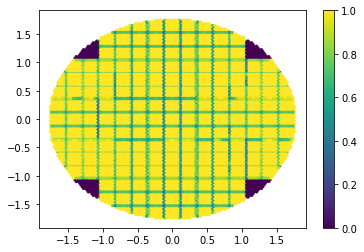

In [12]:
inner = np.where(radius < 1.75)[0]
plt.hexbin(ra.ravel()[inner], dec.ravel()[inner], ack[inner])
plt.colorbar()

In [13]:
for i in range(210):
    inner = np.where(radius<rCut[i])[0]
    fFg[i] = np.mean(ack[inner])

In [14]:
#once we have included all pixels, the geometric fill factor will decrease like 1/r**2
rx = np.linspace(1.8, 2.2, 41)
ry = fF*9.6/np.pi/rx**2

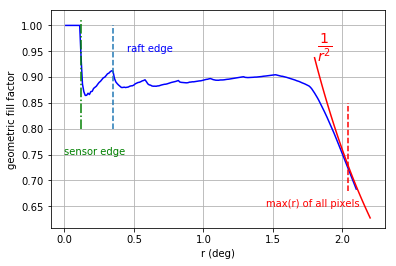

In [15]:
plt.plot(rCut, fFg,'b-')
plt.grid()
plt.plot(rx, ry, 'r')
plt.xlabel('r (deg)')
plt.ylabel('geometric fill factor')

#according to camera drawings, a sensor is 42mm wide, a raft is 127mm wide.
senD = 42/1e-2*0.2/3600
raftD = 127/1e-2*0.2/3600
plt.plot([senD/2, senD/2], [0.8,1.01],'g-.')
plt.plot([raftD/2, raftD/2], [0.8,1],'--')
plt.plot([rMax, rMax], [0.68,.85],'r--')
plt.text(0, 0.75, 'sensor edge',{'color': 'g'})
plt.text(0.45, 0.95, 'raft edge',{'color': 'b'})
plt.text(1.45, 0.65, 'max(r) of all pixels',{'color': 'r'})
plt.text(1.82, 0.95, r'$\frac{1}{r^2}$',{'color': 'r', 'fontsize': 20})